# Low dimensional logistic regression label transfer of variance decomposed Single Cell Data

## Author Notes

* The following tutorial describes a method for integrating data by label transfering based on ridge regulariased logistic regression in low-dimensional space. This approach enables us to fit a model on the annotated training/landscape/reference dataset to predict labels of a new dataset and embed these labels onto neighbourhoods in the prediction data. 

* Logistic regression can (1) be used to classify samples, (2) use different types of data (continuous and descrete measurements)and (3) also be used to assess what variables are useful for classifying samples.

#### Current progress: 
- integrating a latent variable model for neighbourhood construction using factor decomposition. 
- Integration of BIC metric
- Integration of Robustness testing
#### Testing required: 
- Robustness of runs need to be tested by permutation of dependent variables and similairty of outcome tested using MI, RAND or BIC

# Author information

### Created on: 291020; Updated: 050621;
### Author: Issac Goh
### Proof readers/Testers: Simone Webb , Mariana Quiroga Londoño, Anthony Rose

In [3]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

# Only block to edit in LR script

In [4]:
# Introduce variables
# Note that this script expects raw data to be in "non-batch-corrected" adata.raw.X. 

# Required: Introduce the path you'd like to save figures or data to 
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/LR_YS_LIV/LR_ys_fliv_myeloid/"

# Required: Name of first object
data1 = "_ys"
# Provide path to obj1 // landscape/training data
Object1 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad"
# Provide categorical to join between datasets
cat1 = "cell.labels"

# Required: Name of second object
data2 = "_fliv"
# Provide path to obj2 // prediction/projection data
Object2 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Required: LR Model Options
penalty='l2' # can be ["l1","l2","elasticnet"]
#penalty='l2'
sparcity=0.2
max_iter = 200 #Increase if experiencing max iter issues
l1_ratio = 0.5 #If using elasticnet, tis controls the ratio between l1 and l2

# Optional: Batch correction options (this is for correction of eventual combined dataset for data1 and data2)
# If you do not have a batch variable for either data1 or data2, please add a "filler" column in the relevent adata.obs
# for the purposes of batch_correction and batch args below.
# e.g., adata.obs["whatever"] = "something"; batch="whatever"
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ['tissue_fetal_id','tissue_fetal_id',] # Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2

# Optional: miscellaneous Options.   
subsample_train = False # Samples the training data to the smallest fraction (highly dependent on resolution of input celltype categorical). This corrects for proportional differences between celltype labels of interest in the training data. E.g., training data has 50,000 B cells, 20,000 T cells and 100 HSCs. This function will subsample all training to 100 cells per cell type. 
subsample_prop = False # Give this option a proprtion to subsample to(e.g 0.2), if NA given, will subsample to smallest population
subsample_predict = True
subsample_prop_predict = 0.5
remove_non_high_var = True

train_x = 'X_pca' # Define the resource to train and predict on, PCA, X or UMAP (#if you wish to use gene expression, train_x = 'X')
remove_effect_of_custom_gene_list = 'NA' # "./cell_cycle_genes.csv" #remove a custom list of genes from just the variable genes to compute PCA from. Your .csv should have HGNC gene names in the first column to be read in as a vector, any column name is fine.
use_raw = False # Do you want to use adata.raw.X (recommended)

# Read new, reorder and plot

In [ ]:
# This takes an output from Logistic regression output of YS vs EL

In [5]:
crs_tbl = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/LR_YS_LIV/040422_crs_tbl_qc_X_pred_out.csv',header=0,index_col=0)

In [13]:
sort_fliv = ["HSC_fliv",
"MPP_fliv",
"MPP2_fliv",
"CMP_fliv",
"MEMP_fliv",
"LMPP_fliv",
"MLP_fliv",
"ELP_fliv",
"ETP_fliv",
"MOP_fliv",
"Pre_pro_B_progenitor_fliv",
"Pro_B_progenitor_fliv",
"Pre_B_fliv",
"Immature_B_cell_fliv",
#"Pre_ILC_precursor_fliv",
"ILC_precursor_fliv",
"NK_fliv",
"Pre_pDC_fliv",
"pDC_fliv",
"DC1_fliv",
"Pre_DC2_fliv",
"DC2_fliv",
"DC3_fliv",
"Promonocyte_fliv",
"Monocyte_fliv",
"Kupffer_cell_1_fliv",
"Kupffer_cell_2_fliv",
"Promyelocyte_fliv",
"Eo_Basophil_fliv",
"Mast_cell_fliv",
"MK_fliv",
"Early_Erythroid_fliv",
"Embryonic_Erythroid_fliv",
"Erythroid_fliv",]

In [14]:
sort_ys = ["HSPC_1_ys",
"HSPC_2_ys",
"CMP_ys",
"MEMP_ys",
"LMPP_ys",
"Lymphoid_progenitor_ys",
"MOP_ys",
"ILC_precursor_ys",
"NK_ys",
"DC_precursor_ys",
"DC2_ys",
"Promonocyte_ys",
'Monocyte_0_ys',
 'Monocyte_1_ys',
"Monocyte_Macrophage_ys",
"Pre_Macrophage_ys",
"Macrophage_ys",
"Microglia_ys",
"Neutrophil_precursor_ys",
"Eo_Baso_Mast_precursor_ys",
"Eo_Basophil_ys",
"Mast_cell_ys",
"MK_ys",
"Early_Erythroid_ys",
"Erythroid_ys",]

In [8]:
sort_fliv = ["HSC_fliv",
"MPP_fliv",
"MPP2_fliv",
"CMP_fliv",
"MOP_fliv",
"Promonocyte_fliv",
"Monocyte_fliv",
"Kupffer_cell_1_fliv",
"Kupffer_cell_2_fliv",]

In [9]:
sort_ys = ["HSPC_1_ys",
"HSPC_2_ys",
"CMP_ys",
"MOP_ys",
"Promonocyte_ys",
"Monocyte_ys",
"Monocyte_Macrophage_ys",
"Pre_Macrophage_ys",
"Macrophage_ys",
"Microglia_ys",]

# ED3 lymphoid LR

In [ ]:
sort_fliv = ["HSC_fliv",
"MPP_fliv",
"MPP2_fliv",
"CMP_fliv",
"MEMP_fliv",
"LMPP_fliv",
"MLP_fliv",
"ELP_fliv",
"ETP_fliv",
"MOP_fliv",
"Pre_pro_B_progenitor_fliv",
"Pro_B_progenitor_fliv",
"Pre_B_fliv",
"Immature_B_cell_fliv",
#"Pre_ILC_precursor_fliv",
"ILC_precursor_fliv",
"NK_fliv",
"Pre_pDC_fliv",
"pDC_fliv",
"DC1_fliv",
"Pre_DC2_fliv",
"DC2_fliv",
"DC3_fliv",
"Promonocyte_fliv",
"Monocyte_fliv",
"Kupffer_cell_1_fliv",
"Kupffer_cell_2_fliv",
"Promyelocyte_fliv",
"Eo_Basophil_fliv",
"Mast_cell_fliv",
"MK_fliv",
"Early_Erythroid_fliv",
"Embryonic_Erythroid_fliv",
"Erythroid_fliv",]

sort_ys = ["HSPC_1_ys",
"HSPC_2_ys",
"CMP_ys",
"MEMP_ys",
"LMPP_ys",
"Lymphoid_progenitor_ys",
"MOP_ys",
"ILC_precursor_ys",
"NK_ys",
"DC_precursor_ys",
"DC2_ys",
"Promonocyte_ys",
'Monocyte_0_ys',
 'Monocyte_1_ys',
"Monocyte_Macrophage_ys",
"Pre_Macrophage_ys",
"Macrophage_ys",
"Microglia_ys",
"Neutrophil_precursor_ys",
"Eo_Baso_Mast_precursor_ys",
"Eo_Basophil_ys",
"Mast_cell_ys",
"MK_ys",
"Early_Erythroid_ys",
"Erythroid_ys",]

In [28]:
crs_tbl = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/LR_YS_LIV/040422_crs_tbl_qc_X_pred_out_v2.csv',index_col=0)

In [29]:
crs_tbl 

,HSPC_1_ys,HSPC_2_ys,CMP_ys,MEMP_ys,LMPP_ys,Lymphoid_progenitor_ys,MOP_ys,ILC_precursor_ys,NK_ys,DC_precursor_ys,...,Pre_Macrophage_ys,Macrophage_ys,Microglia_ys,Neutrophil_precursor_ys,Eo_Baso_Mast_precursor_ys,Eo_Basophil_ys,Mast_cell_ys,MK_ys,Early_Erythroid_ys,Erythroid_ys
orig_labels,,,,,,,,,,,,,,,,,,,,,
HSC_fliv,9.604745e+01,3.372212e-01,5.635994e-02,9.169641e-02,1.767898e+00,3.486332e-02,5.884213e-03,3.173636e-02,7.312867e-03,3.118359e-02,...,3.935259e-02,0.001212,6.280000e-06,1.083732e-02,2.197721e-02,7.882468e-03,7.092104e-03,2.519576e-02,0.013971,1.534655e-03
MPP_fliv,9.071854e+01,2.133810e+00,8.716984e-02,1.429892e-01,2.318442e+00,2.802539e-02,7.194488e-03,3.119657e-02,7.869588e-03,1.056065e-02,...,4.119291e-02,0.000785,5.360000e-07,9.473861e-03,3.133569e-02,9.174028e-03,4.875766e-03,2.256995e-02,0.029261,9.434110e-04
MPP2_fliv,1.174524e-01,9.664754e+01,1.356357e-01,3.415987e-01,5.030895e-01,2.199121e-02,1.137325e-02,4.467240e-02,1.428621e-02,4.114689e-03,...,8.150043e-02,0.001367,1.980000e-08,8.657489e-03,1.879944e-01,1.993567e-02,1.258275e-02,1.324377e-01,0.054283,9.729810e-04
CMP_fliv,5.125990e-01,9.788066e-01,9.245512e+01,2.335064e-01,3.244369e-01,2.569850e-02,9.849432e-01,4.417329e-02,1.028977e-02,1.069465e-02,...,3.297802e-02,0.004019,7.290000e-07,3.266732e-01,4.158089e-02,1.512850e-02,8.132719e-03,2.201106e-02,0.074482,5.761320e-04
MEMP_fliv,3.624525e-03,2.668351e-01,8.720581e-03,9.001768e+01,2.123570e-03,6.948700e-04,1.023754e-03,2.117530e-03,7.552630e-04,3.690920e-04,...,8.523650e-04,0.001012,4.260000e-08,8.214530e-04,3.137566e-02,2.285670e-03,1.361138e-03,9.644730e+01,0.017648,1.368100e-04
LMPP_fliv,1.897709e+00,1.093840e+00,1.296548e-01,5.425022e-02,1.619486e+00,9.492052e+01,1.412527e-02,5.309741e-02,2.306222e-02,5.458273e-02,...,8.641325e-02,0.001873,2.810000e-07,8.683473e-03,1.626005e-02,1.162206e-02,1.755896e-03,1.079569e-02,0.175481,2.000613e-03
MLP_fliv,9.132815e+01,2.492551e-01,7.897744e-02,6.965988e-02,6.341635e+00,2.219782e-01,5.353877e-03,5.514076e-02,9.385620e-03,2.737487e-02,...,4.993692e-02,0.000515,1.550000e-06,1.327164e-02,2.542431e-02,9.697924e-03,6.184901e-03,2.329410e-02,0.018415,1.108672e-03
ELP_fliv,2.779113e-03,1.869042e-01,1.993656e-02,1.288582e-02,3.556938e-01,1.708897e+01,5.087161e-03,9.193867e-02,2.254579e-02,1.626591e-01,...,8.330159e-03,0.012162,2.530000e-08,2.875382e-03,1.103161e-02,1.198793e-02,1.300736e-03,2.223501e-03,0.016021,6.063330e-04
ETP_fliv,1.679659e-01,1.927261e-03,3.316753e-03,6.203899e-03,1.455248e-01,1.798645e+01,1.264055e-03,7.605180e-02,2.146072e-02,5.218151e-01,...,2.876097e-03,0.001793,5.370000e-06,5.024141e-03,6.310755e-03,3.832040e-03,3.599053e-03,1.312456e-03,0.002173,5.204670e-04


Text(562.2252840909092, 0.5, 'Predicted labels')

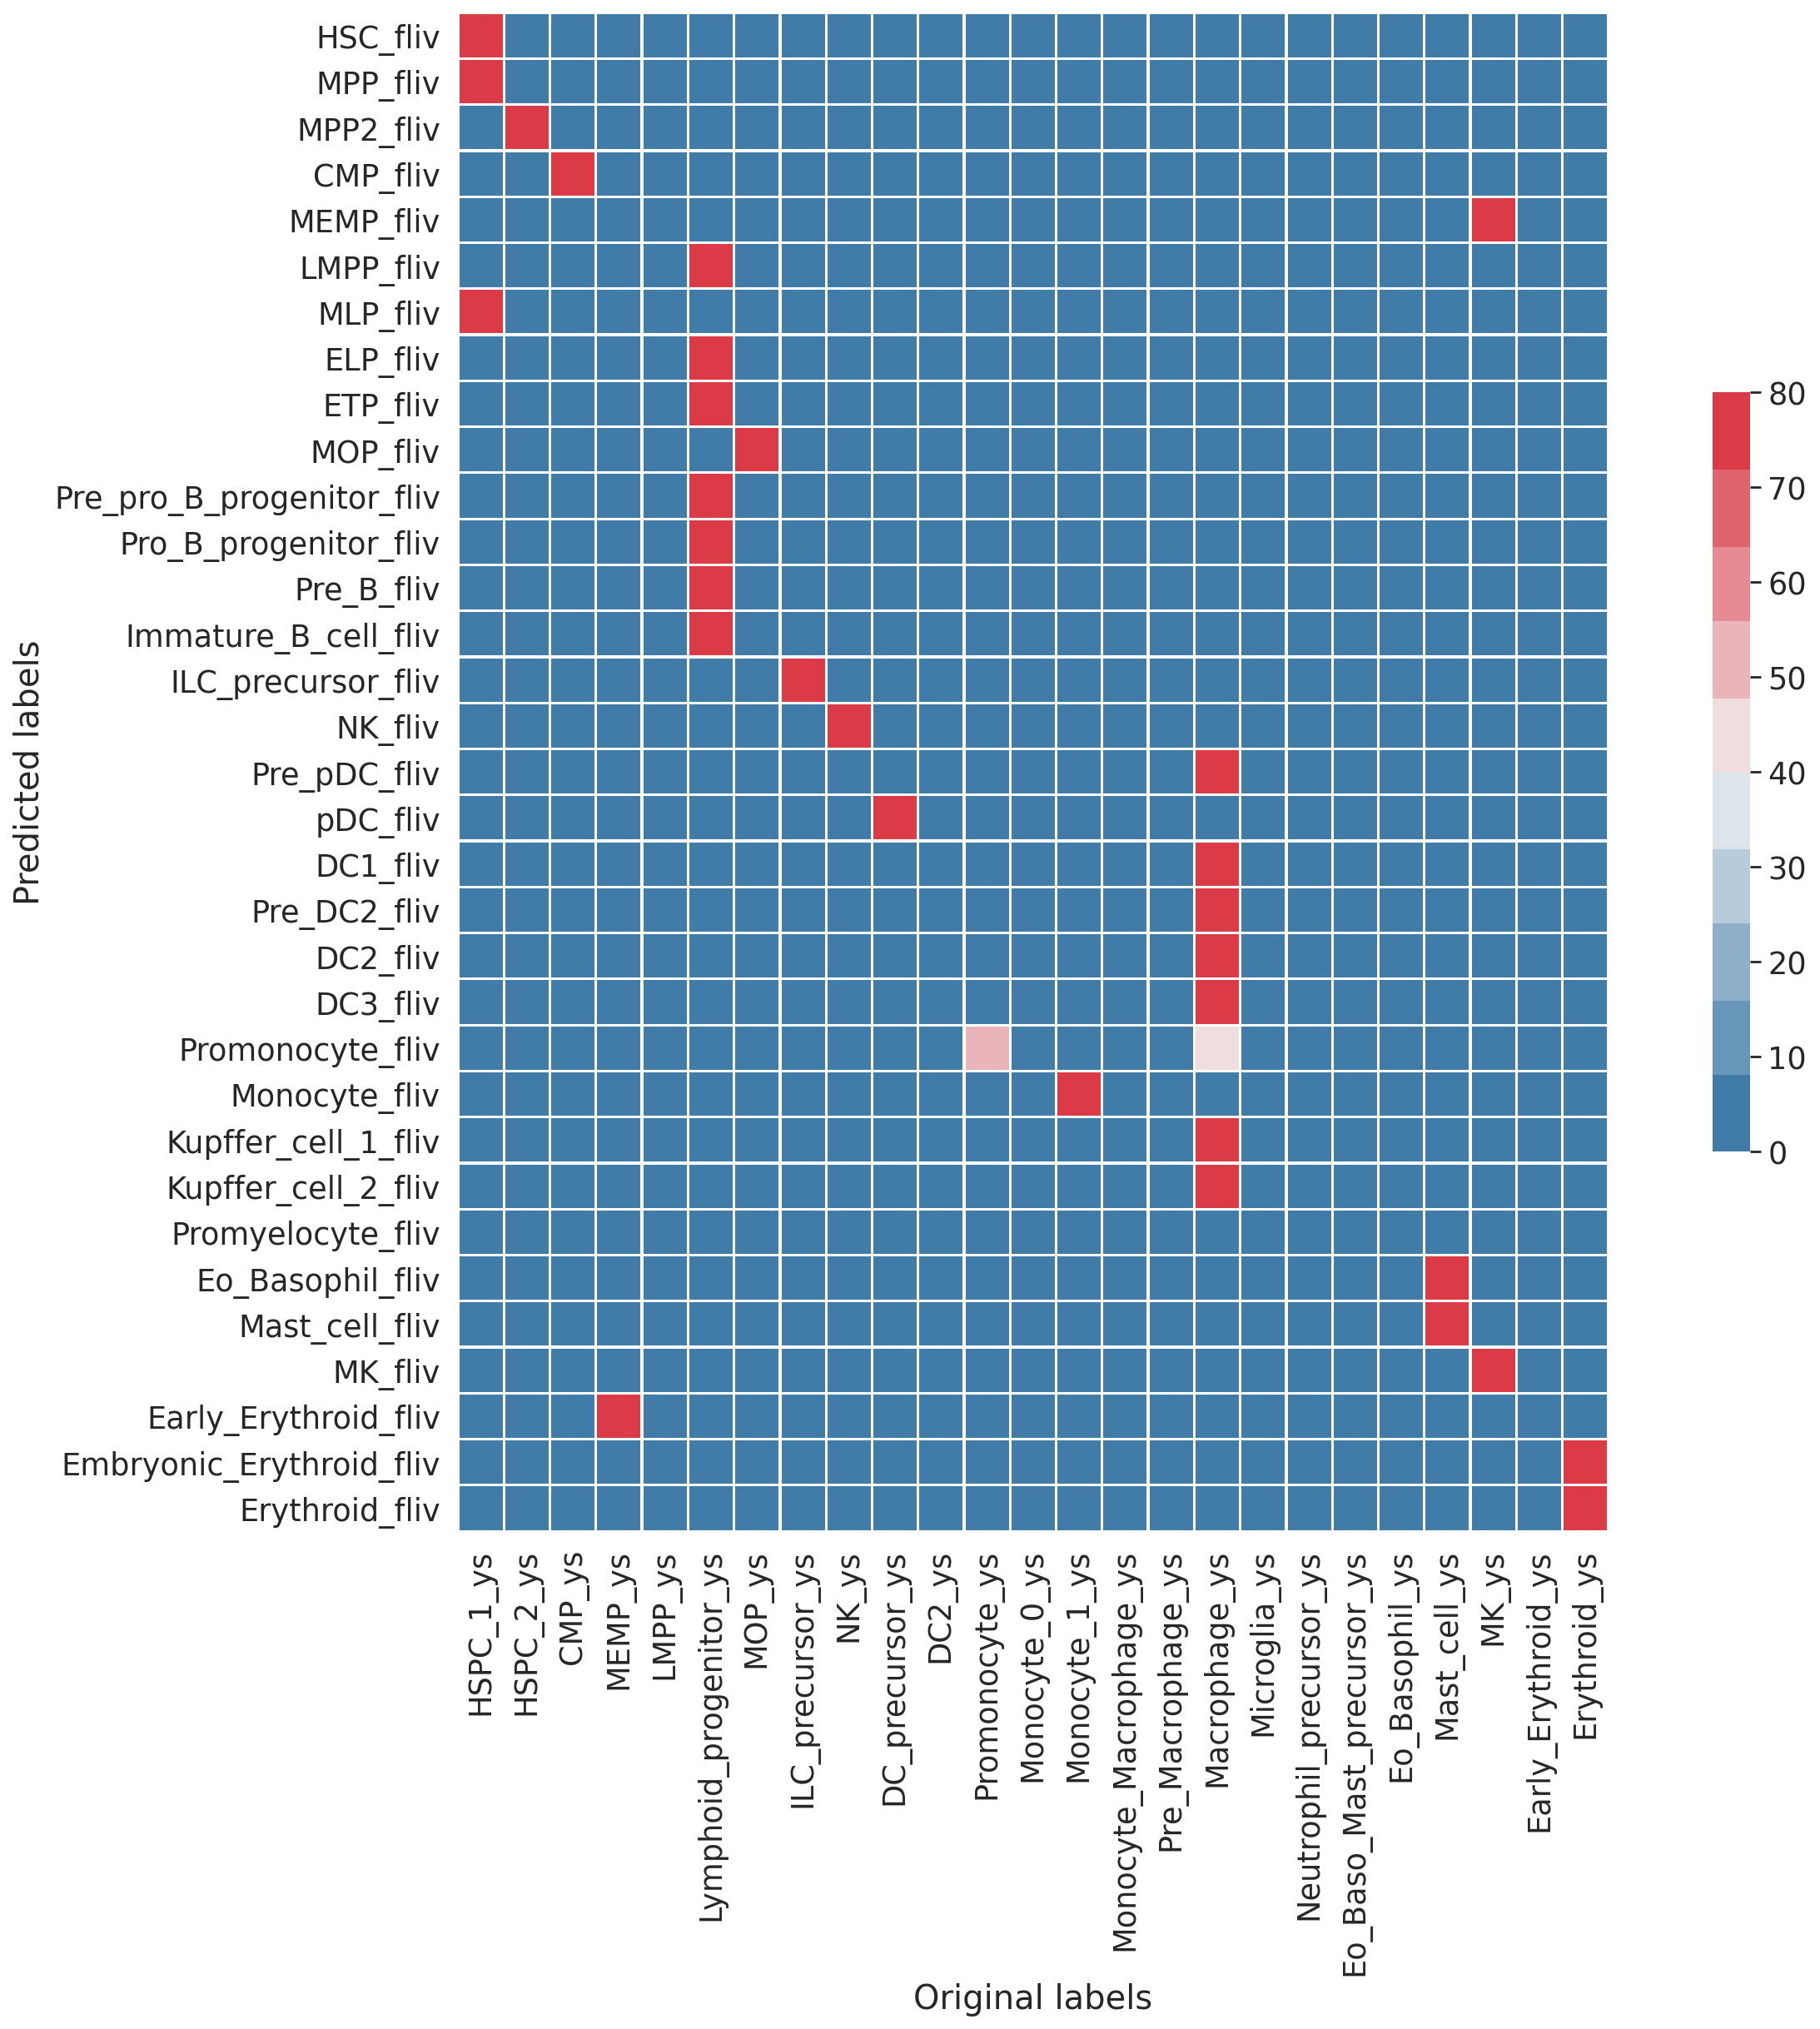

In [18]:
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=1.5)
g = sns.heatmap(crs_tbl.T, cmap=pal, vmin=0, vmax=80, linewidths=1, center=40, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
# plt.savefig(save_path + "/fmye_train_ys_cell_labels_fliv_ys_broad_LR_predictions.pdf")
# crs_tbl.to_csv(save_path + "/mye_train_ys_cell_labels_ys_broad_pre-freq_LR_predictions_supp_table.csv")

In [30]:
crs_tbl = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV/FIG_2C/train_ys_cell_labels_ys_broad_pre-freq_LR_predictions_supp_table.csv',header=0,index_col=0)

In [19]:
sort_fliv = [
"MOP_fliv",
"Promonocyte_fliv",
"Monocyte_fliv",
"Kupffer_cell_1_fliv",
"Kupffer_cell_2_fliv",]

sort_ys = [
"MOP_ys",
"Promonocyte_ys",
'Monocyte_0_ys',
 'Monocyte_1_ys',
"Monocyte_Macrophage_ys",
"Pre_Macrophage_ys",
"Macrophage_ys",
"Microglia_ys",]
crs_tbl = crs_tbl.T[sort_ys]
crs_tbl = crs_tbl.T[sort_fliv]

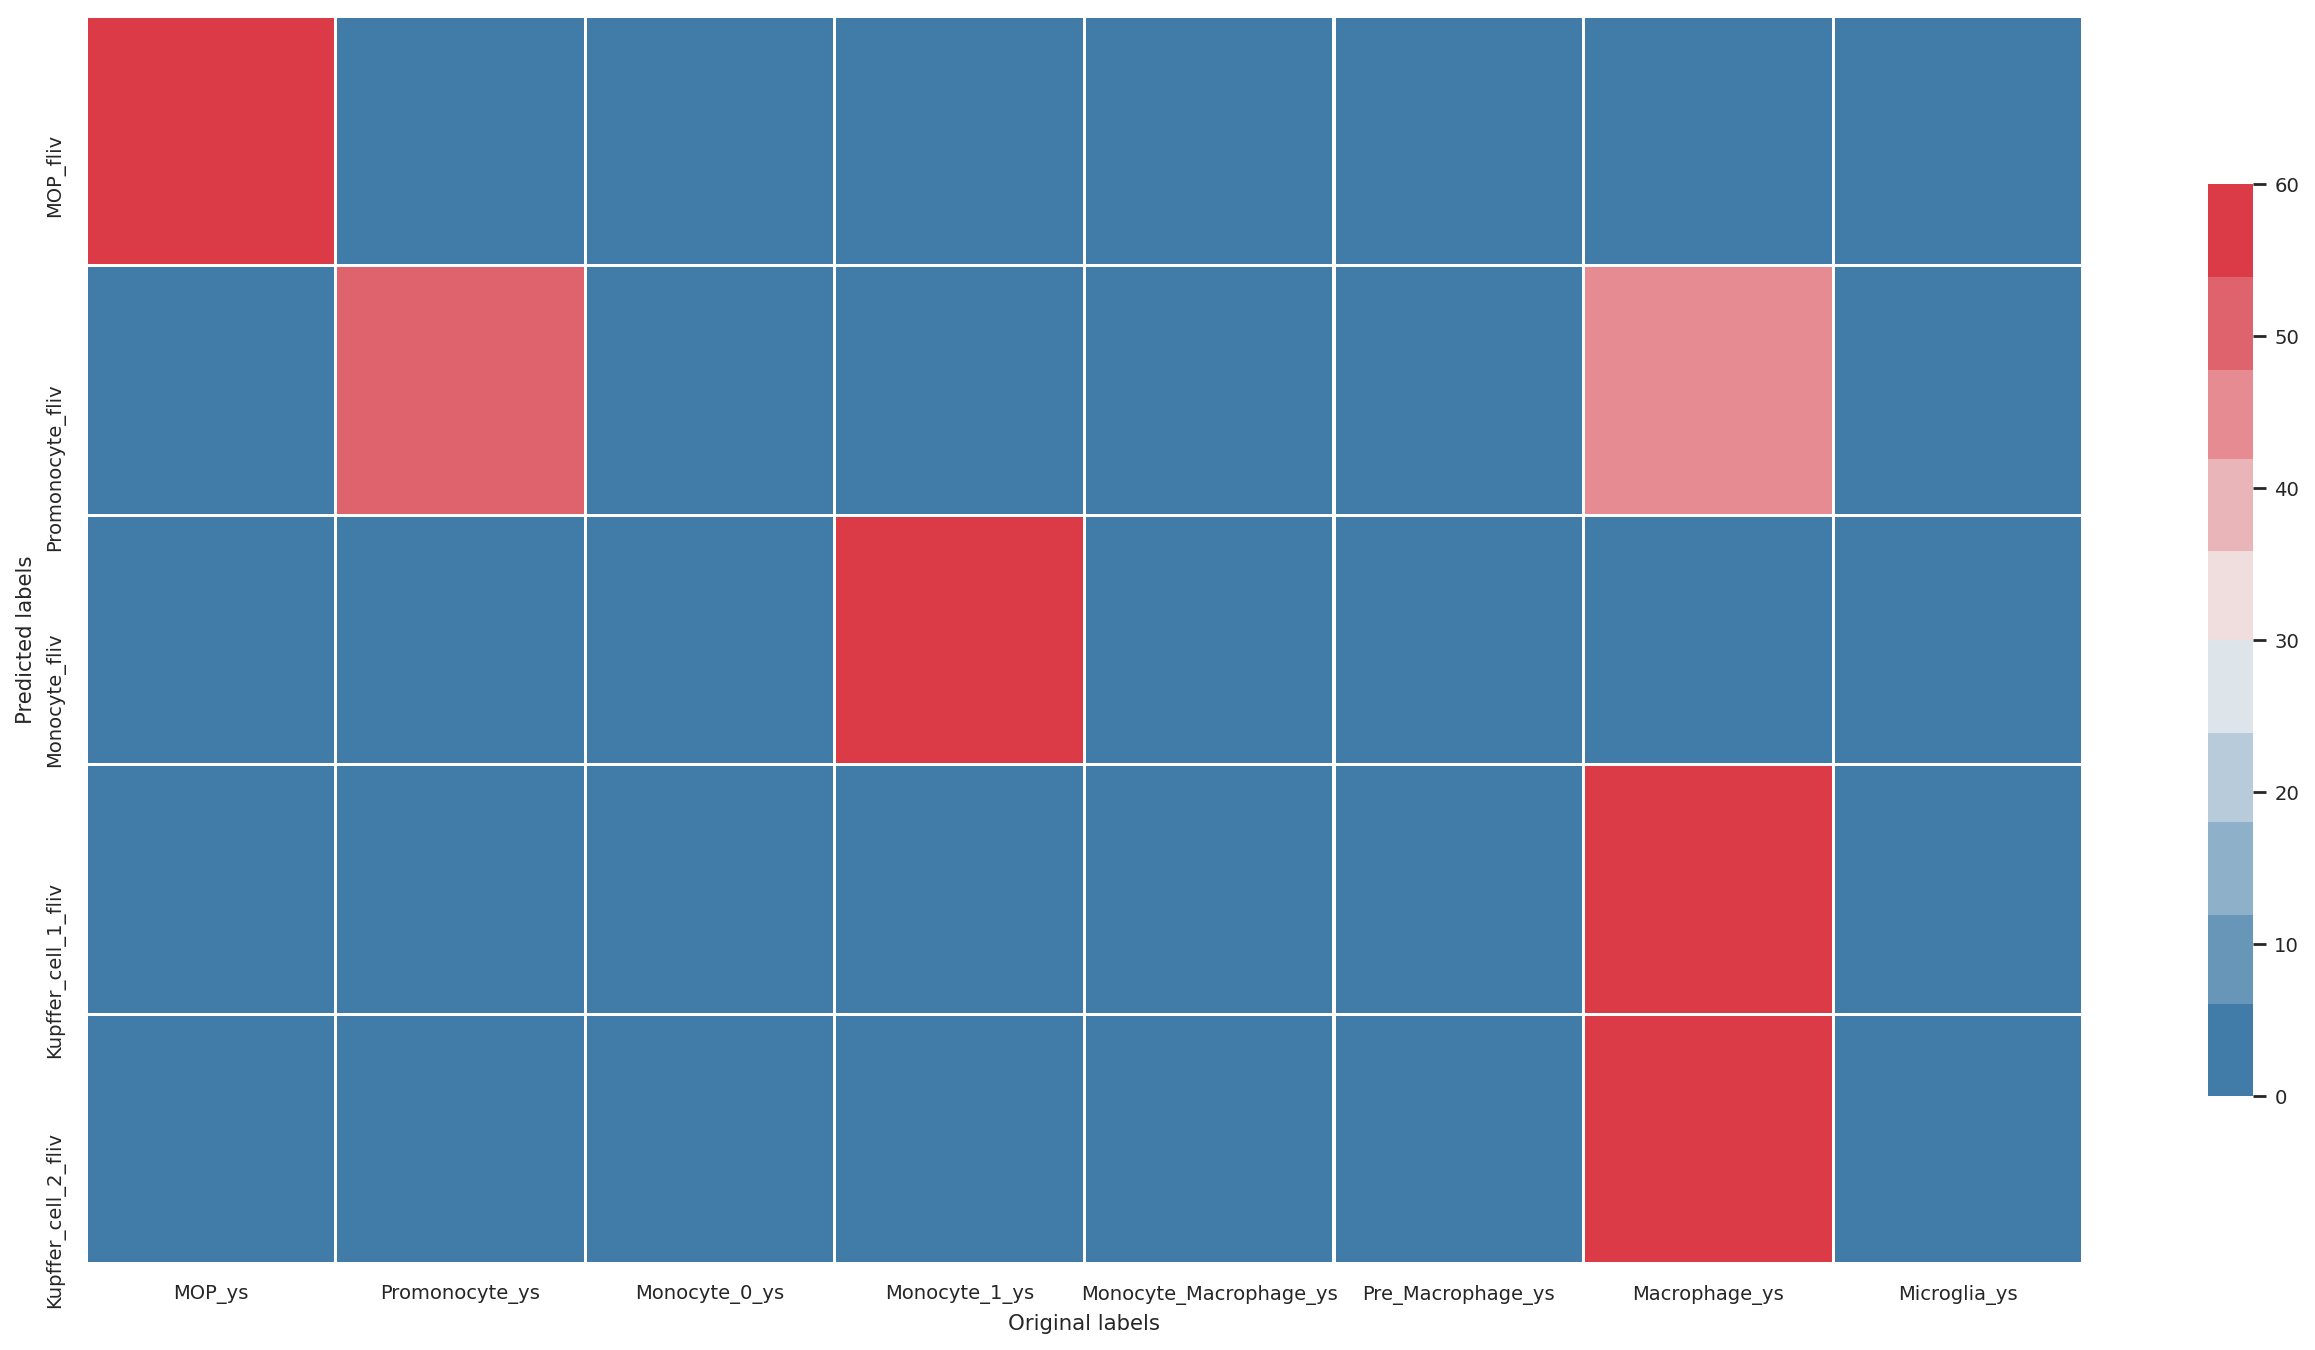

In [21]:
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl.T, cmap=pal, vmin=0, vmax=60, linewidths=1, center=30, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig( "./040422_no_progen_mye_train_ys_cell_labels_fliv_ys_broad_LR_predictions.pdf")
crs_tbl.to_csv( "./040422_no_progen_mye_train_ys_cell_labels_ys_broad_pre-freq_LR_predictions_supp_table.csv")

In [59]:
crs_tbl = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV/FIG_2C/train_ys_cell_labels_ys_broad_pre-freq_LR_predictions_supp_table.csv',header=0,index_col=0)
crs_tbl

,HSC_fliv,MPP_fliv,MPP2_fliv,CMP_fliv,MEMP_fliv,LMPP_fliv,MLP_fliv,ELP_fliv,ETP_fliv,MOP_fliv,...,Monocyte_fliv,Kupffer_cell_1_fliv,Kupffer_cell_2_fliv,Promyelocyte_fliv,Eo_Basophil_fliv,Mast_cell_fliv,MK_fliv,Early_Erythroid_fliv,Embryonic_Erythroid_fliv,Erythroid_fliv
predicted,,,,,,,,,,,,,,,,,,,,,
HSPC_1_ys,96.60,58.02,43.04,11.98,0.30,12.82,81.45,4.23,19.83,0.00,...,0.17,0.00,0.00,12.08,2.81,0.00,0.00,0.05,0.60,0.02
HSPC_2_ys,0.97,35.13,41.27,37.39,10.65,29.06,1.61,14.08,0.00,0.39,...,0.00,0.00,0.00,4.15,2.81,0.00,0.13,0.65,1.19,0.00
CMP_ys,0.00,0.28,0.00,41.92,0.00,0.00,0.00,0.00,0.00,1.18,...,0.00,0.00,0.00,19.25,0.00,0.00,0.00,0.05,0.00,0.00
MEMP_ys,0.24,0.00,2.03,0.91,73.83,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.38,6.88,2.09,0.00,32.59,0.60,0.00
LMPP_ys,0.00,3.24,0.00,1.27,0.00,43.59,3.23,10.99,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Lymphoid_progenitor_ys,0.00,0.09,0.00,0.18,0.00,10.26,12.63,65.35,71.90,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MOP_ys,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.28,0.00,43.14,...,1.98,0.00,0.00,22.64,0.00,0.00,0.00,0.00,0.00,0.02
ILC_precursor_ys,0.00,0.09,0.00,0.00,0.00,0.85,0.00,0.28,1.10,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NK_ys,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.86,0.00,...,0.33,0.00,0.00,0.00,0.00,0.52,0.07,0.02,0.00,0.00


In [60]:
save_path = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/LR_YS_LIV/'

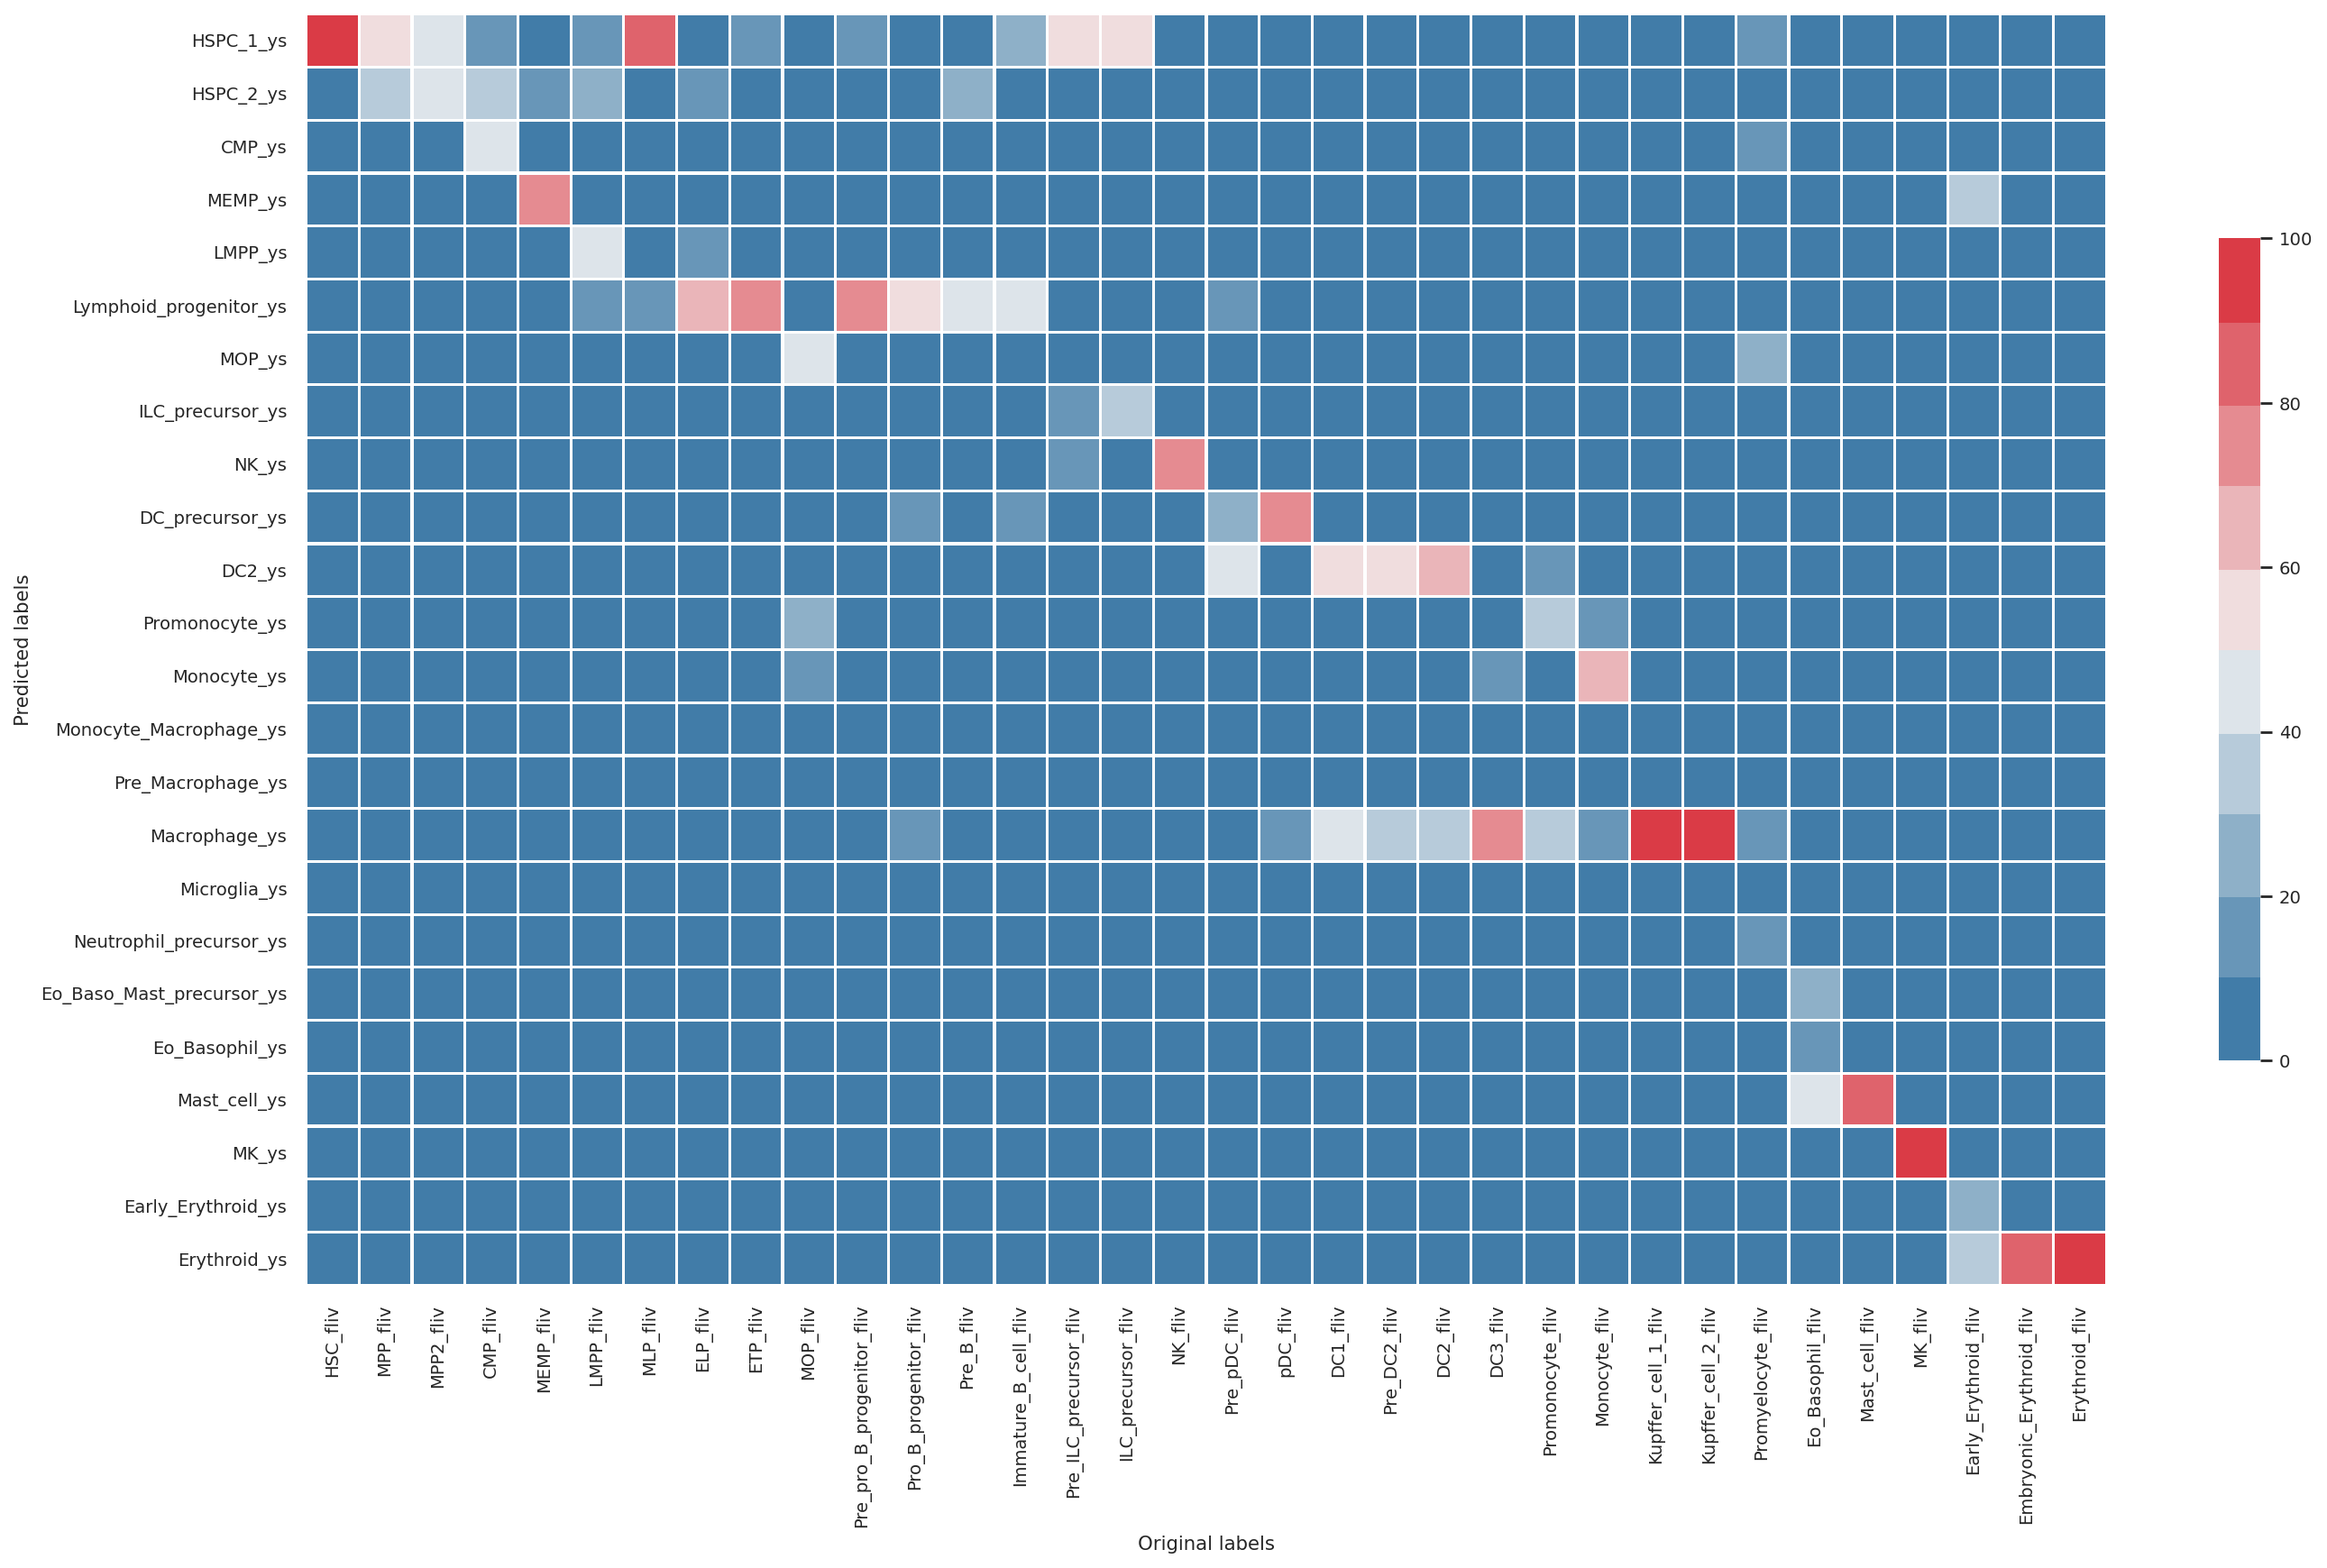

In [61]:
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions.pdf")
crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

In [ ]:
crs_tbl = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/endo_LR_BM/including_endo_lr/no_endo_pre-freq_LR_predictions_supp_table.csv',index_col=0)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions.pdf")
crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

In [13]:
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()

### Proportion of cells per group

In [ ]:
prop = adata.obs.groupby('predicted').count()
prop['percentage'] = (prop.iloc[:,6]/prop.iloc[:,6].sum())*100
prop = prop['percentage']
prop.to_csv(save_path + "/pre-freq_predicted_prop.csv")
prop

## Modules to compute Leiden-LR Consensus

## Clustering 

In [ ]:
# Optional clustering 
res = 5
key_add = 'leiden'
adata.obs[key_add] = "nan"
sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

In [ ]:
cluster_prediction = "clus_prediction"
clusters_reassign = "leiden"
lr_predicted_col = 'predicted'

In [ ]:
adata.obs[cluster_prediction] = adata.obs.index
for z in adata.obs[clusters_reassign].unique():
    df = adata.obs
    df = df[(df[clusters_reassign].isin([z]))]
    df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
    freq_arranged = df_count.index
    cat = freq_arranged[0]
    df.loc[:,cluster_prediction] = cat
    adata.obs.loc[adata.obs[clusters_reassign] == z, [cluster_prediction]] = cat

### Heatmap showing cells in predicted clusters

In [ ]:
# Create a concat col for old + predicted annots
adata.obs['annot_clus_prediction_concat'] = adata.obs[cat1].astype(str) + "_" + adata.obs['clus_prediction'].astype(str)

x='clus_prediction'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)

#plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,10))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.3})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions_consensus.pdf")
crs_tbl.to_csv(save_path + "/post-freq_LR_predictions_consensus_supp_table.csv")

In [ ]:
prop = adata.obs.groupby('clus_prediction').count()
prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
prop = prop['percentage']
prop.to_csv(save_path + "/post-freq_predicted_leiden_consensus_prop.csv")
prop

In [ ]:
# Generate a umap to view your current data
sc.tl.umap(adata)

def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

col = generate_colors(len(adata.obs["predicted"].unique()))
sc.pl.umap(adata, color='predicted', palette = col, save = "prediction_umap.pdf")

col = generate_colors(len(adata.obs["clus_prediction"].unique()))
sc.pl.umap(adata, color='clus_prediction', palette = col, save = "clus_prediction_umap.pdf")

In [ ]:
# Are any celltypes removed between prediction and cluster consensus step?
prediction_set = list(adata.obs['predicted'].unique())
clust_prediction_set = list(adata.obs['clus_prediction'].unique())
non_intersect = set(prediction_set) ^ set(clust_prediction_set)
non_intersect = non_intersect.intersection(prediction_set)

if (len(non_intersect)>0):
    print(str(len(non_intersect)) + " labels were omitted during the consensus redistribution step! Please check if these labels are expected to be significantly available in the prediction dataset! Missin labels are::" )
    print("################################")
    print(non_intersect)
    
    # plot umap coloring only labels that were lost in consensus step
    sc.pl.umap(adata,color="predicted",groups=non_intersect, save = "freq_redistribution_omitted_labels_umap.pdf")
else: print("No labels were omitted!")

In [ ]:

# calculate Rand and MI
rand = sklearn.metrics.adjusted_rand_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']))
mi = sklearn.metrics.adjusted_mutual_info_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']), 
                                                average_method='arithmetic')

# test concordance between the predicted labels by cell and the consensus clusters
if ((rand<0.8) | (mi<0.8)):
    print("Your concordance between predicted and consensus leiden labels are weak, please attempt reclustering at higher resolution and running consensus again")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))
else: 
    print("success")
    print("You have achieved good consensus between predicted labels and consensus leiden labels")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))

In [ ]:
# Note: if low could be due to removed celltypes or may be expected if the cells are quite different such as from different organs, 
# plot cells to check groups and see if group together nicely or all over 

# Save dataframe with new labels 

In [ ]:
df = adata.obs[["predicted", "leiden", "clus_prediction"]]
df = df.rename(columns={"predicted": "pre_freq_clus_prediction", "clus_prediction": "post_freq_clus_prediction"})
df.to_csv(save_path + "/final_lr_metadata_for_adata2.csv")
df